# Facial Keypoints - Inference

In this a haar cascade is used to find faces in images.

The trained model from '1_Train.ipynb' is used to identify the facial keypoints in every face in the image

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

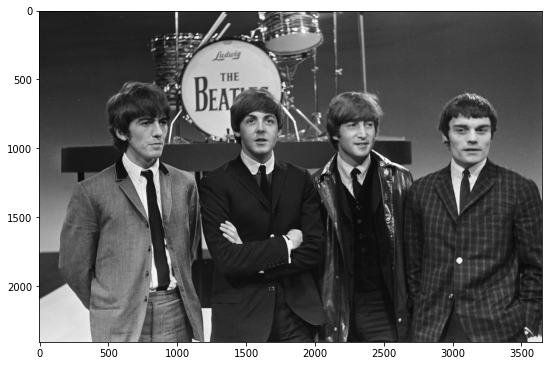

In [7]:
import cv2

IMAGE_FILE = "images/the_beatles.jpg"

image = cv2.imread(IMAGE_FILE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(9,9))
plt.imshow(image)

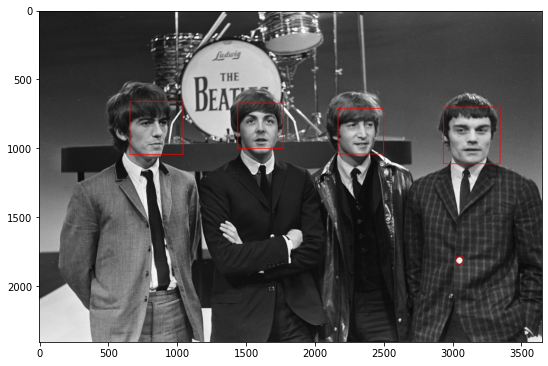

In [8]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
faces = face_cascade.detectMultiScale(image, 1.2, 8)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [9]:
## load the best saved model parameters

import torch
from facepoint.models import Net

net = Net()

net.load_state_dict(torch.load('saved_models/facenet.pt'))
net.eval()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 24, kernel_size=(2, 2), stride=(1, 1))
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3456, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=136, bias=True)
)

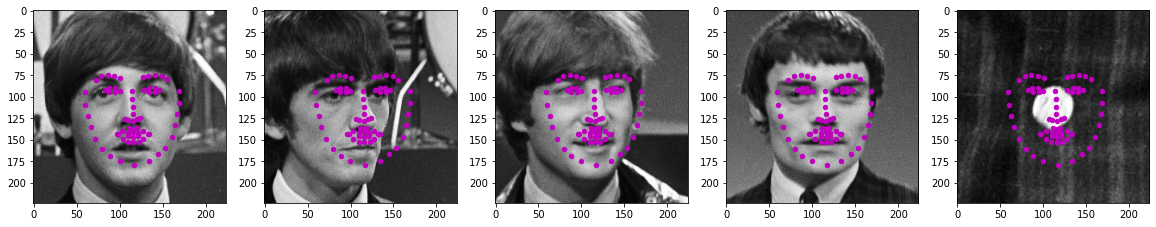

In [10]:
image_copy = np.copy(image)
plt.figure(figsize=(20,10))

# loop over the detected faces from your haar cascade
for i, (x,y,w,h) in enumerate(faces):
    padding = 80
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y-padding:y+h+padding, x-padding:x+w+padding]
    
    # Convert the face region from RGB to grayscale
    roi_grey = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    # Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi_grey = roi_grey/255.0
    # Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi_grey = cv2.resize(roi_grey, (224, 224))
    # Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi_grey = np.expand_dims(roi_grey, axis=0)
    roi_grey = np.expand_dims(roi_grey, axis=0)

    # perform a forward pass to get the predicted facial keypoints
    img_tensor = torch.from_numpy(roi_grey).type(torch.FloatTensor)
    
    output = net(img_tensor)
    output = output*50 + 100
    output = output.data.numpy().reshape(-1, 2)
    
    # Display each detected face and the corresponding keypoints        
    ax = plt.subplot(1, len(faces), i+1)
    ax.imshow(np.squeeze(roi_grey), cmap='gray')
    ax.scatter(output[:,0], output[:, 1], s=20, c='m')
    